In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


In [2]:
import albumentations as A
import torchvision.transforms as transforms
import torch
from PIL import Image
from albumentations.pytorch import ToTensor
from plot_graph import plot_images, plot_graph
from utilities import *
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [3]:
## importing and transforming data
from read_inputs import read_transform_inputs
trainset, trainloader, testset, testloader, classes = read_transform_inputs()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship  deer  deer plane


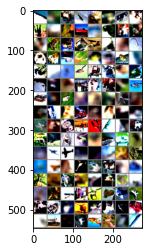

In [4]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
## defining model

from define_model import ResNet
from define_model import BasicBlock
from define_model import Bottleneck
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [6]:
##defining optimiser
from define_optim import optim_define
optimizer = optim_define(model)

In [7]:
## defining accuracy check and defining the training class
from truth_checker import truth_checker
from training_class import training_class
clf = training_class(model=model,trainloader = trainloader,testloader= testloader,device=device,
                     epoch=5,optimizer=optimizer)

In [25]:
#clf.fit()

In [8]:
from train import train
from test import test
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.1, epochs=epochs,
                       steps_per_epoch=len(trainloader))

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(epochs):
      print("EPOCH:", epoch+1)
      train(model, device, trainloader, criterion, optimizer, epoch, l1_decay, l2_decay, scheduler)
      test(model, device, testloader, criterion, classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==epochs-1)
  return test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=3e-6, l2_decay=1e-3)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=459.2781066894531 L1_loss=106551.6796875 Loss=2.64370059967041 Batch_id=390 Accuracy=29.01: 100%|██████████| 391/391 [00:56<00:00,  6.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0134, Accuracy: 3901/10000 (39.01%)

EPOCH: 2


L2_loss=453.5211181640625 L1_loss=100326.3828125 Loss=2.6822776794433594 Batch_id=390 Accuracy=38.26: 100%|██████████| 391/391 [00:58<00:00,  6.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0119, Accuracy: 4461/10000 (44.61%)

EPOCH: 3


L2_loss=447.428955078125 L1_loss=95408.515625 Loss=2.2837188243865967 Batch_id=390 Accuracy=43.43: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0108, Accuracy: 5033/10000 (50.33%)

EPOCH: 4


L2_loss=442.2023010253906 L1_loss=92009.2109375 Loss=1.9926872253417969 Batch_id=390 Accuracy=47.48: 100%|██████████| 391/391 [01:00<00:00,  6.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0097, Accuracy: 5651/10000 (56.51%)

EPOCH: 5


L2_loss=440.1103820800781 L1_loss=90874.3203125 Loss=1.9341477155685425 Batch_id=390 Accuracy=52.61: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]
/content/test.py:23: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  misclassified_inds = (is_correct == 0).nonzero()[:, 0]


Test set: Average loss: 0.0086, Accuracy: 6110/10000 (61.10%)



In [9]:
PATH = 'model.sav'
torch.save(model.state_dict(), PATH)

#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))


In [23]:
### training process initiation
#from train_iteration import train
#criterion = nn.CrossEntropyLoss()
#train(50,trainloader,device,optimizer,model,criterion)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


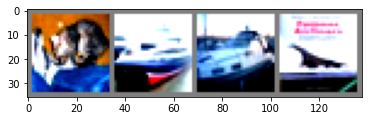

In [10]:
## checking test images

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

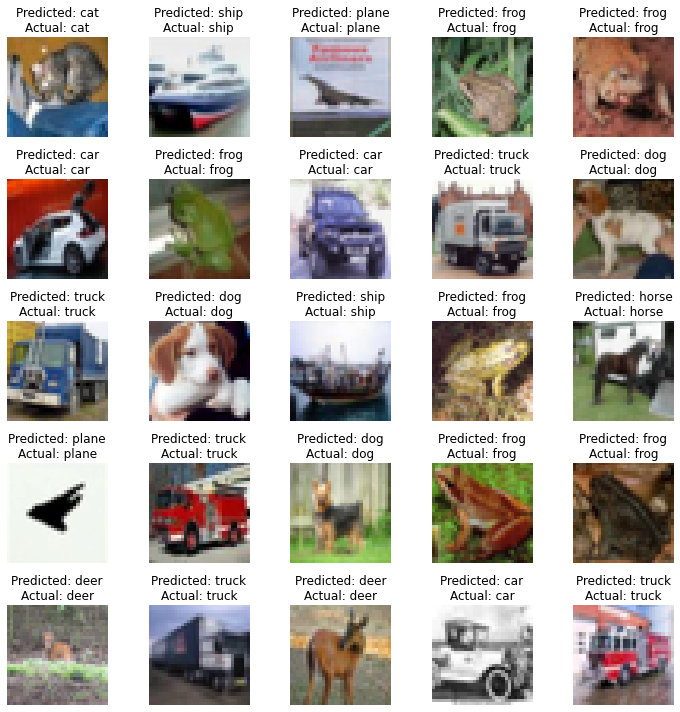

In [11]:
## correct images
plot_images(correct_imgs, classes, "correct_imgs.png")

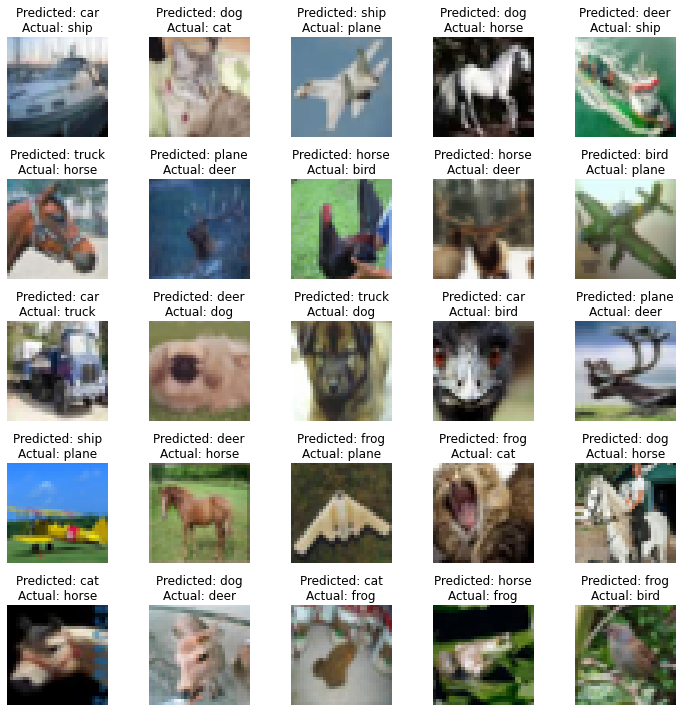

In [12]:
plot_images(misclassified_imgs, classes, "misclassified_imgs.png")

In [13]:
from accuracy_check import check_accuracy     
check_accuracy(testloader,device,model)

Accuracy of the network on the 10000 test images: 61 %


61.1

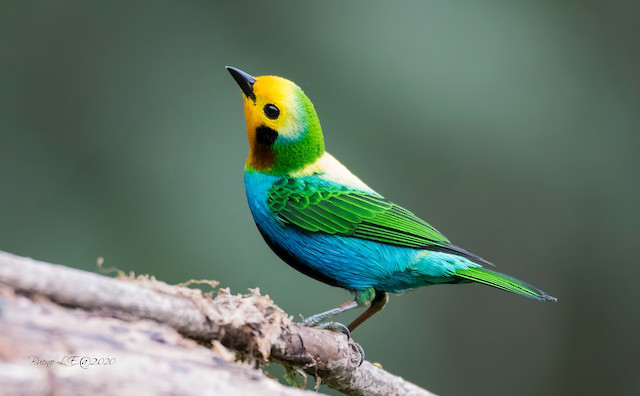

In [19]:
import PIL
pil_img = PIL.Image.open('/content/bird_image.jpg')
pil_img


In [20]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [16]:
configs = [
    
    dict(model_type='resnet', arch=model, layer_name='layer4'),
    
]

In [17]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [21]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

RuntimeError: ignored

In [ ]:
transforms.ToPILImage()(grid_image)

In [30]:
from skimage import io
preprocessing = transforms.Compose([
        transforms.ToTensor(),
    ])
image = io.imread('https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png') 
image = np.float32(image) / 255
image = cv2.resize(image, (32, 32))
image = preprocessing(image.copy())
#image = image[:, :, ::-1]
print(image.shape)





def preprocess_image(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    preprocessing = transforms.Compose([
        normalize,
    ])
    return preprocessing(img.unsqueeze(0))
input_img = preprocess_image(image)


torch.Size([3, 32, 32])


In [18]:
configs = [dict(model_type='resnet', arch=model, layer_name='layer4')]
cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]
images = []
for gradcam, gradcam_pp in cams:
  
    mask, _ = gradcam(input_img)
    heatmap, result = visualize_cam(mask, image)

    mask_pp, _ = gradcam_pp(input_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, image)
    
    images.extend([image.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=1)

AttributeError: ignored